# DESeq2 Analysis

The popular DESeq2 package in R is used to perform differential gene expression analysis.
DESeq2 is widely used for bulk RNA-seq count data, offering robust statistical methods to identify genes that are differentially expressed between experimental conditions.
The goal is to take raw count data, normalize it, and extract insights from significant changes in gene expression.

In [1]:
## Load data.
# Here we have the raw counts, which is the exact input we want for DESeq2.
# Raw counts are generated by tools such as featureCounts or HTSeq-count. 
counts_path <- file.path("../data/GSE164073_raw_counts_GRCh38.p13_NCBI.tsv.gz")
counts <- read.delim((counts_path))

# Observe the data
head(counts)

,GeneID,GSM4996084,GSM4996085,GSM4996086,GSM4996087,GSM4996088,GSM4996089,GSM4996090,GSM4996091,GSM4996092,GSM4996093,GSM4996094,GSM4996095,GSM4996096,GSM4996097,GSM4996098,GSM4996099,GSM4996100,GSM4996101
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,100287102,2,5,3,2,5,2,4,2,3,2,2,4,3,2,2,3,3,3
2,653635,244,236,337,266,317,226,303,196,219,202,168,201,235,221,270,262,234,314
3,102466751,25,17,34,22,24,19,23,15,21,15,19,22,15,17,16,18,17,23
4,107985730,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,100302278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,645520,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
library(dplyr, quietly = TRUE)
library(tibble, quietly = TRUE)
# Set rownames to gene identifiers
count_mat <- counts %>%
  tibble::column_to_rownames("GeneID") %>%
  as.matrix()

print(head(count_mat))

          GSM4996084 GSM4996085 GSM4996086 GSM4996087 GSM4996088 GSM4996089
100287102          2          5          3          2          5          2
653635           244        236        337        266        317        226
102466751         25         17         34         22         24         19
107985730          1          1          1          0          0          0
100302278          0          0          0          0          0          0
645520             0          0          0          0          1          0
          GSM4996090 GSM4996091 GSM4996092 GSM4996093 GSM4996094 GSM4996095
100287102          4          2          3          2          2          4
653635           303        196        219        202        168        201
102466751         23         15         21         15         19         22
107985730          1          0          0          0          0          0
100302278          0          0          0          0          0          0
645520      

In [6]:
# Now we need to prepare a metadata table -
# so that DESeq2 knows which conditions exist and which comparisons are possible

# 
sample_info <- data.frame(
  tissue = rep(c("Cornea", "Limbus", "Sclera"), each = 6),
  condition = rep(rep(c("mock", "CoV2"), each = 3), times = 3),
  replicate = rep(1:3, times = 6),
  row.names = colnames(count_mat),
  stringsAsFactors = TRUE
)

# View the result and ensures it matches the information from GEO
sample_info

,tissue,condition,replicate
,<fct>,<fct>,<int>
GSM4996084,Cornea,mock,1
GSM4996085,Cornea,mock,2
GSM4996086,Cornea,mock,3
GSM4996087,Cornea,CoV2,1
GSM4996088,Cornea,CoV2,2
GSM4996089,Cornea,CoV2,3
GSM4996090,Limbus,mock,1
GSM4996091,Limbus,mock,2
GSM4996092,Limbus,mock,3


In [10]:
library(DESeq2, quietly = TRUE)
# Create DESeqDataSet object
dds <- DESeqDataSetFromMatrix(
  countData = count_mat,
  colData = sample_info,
  design = ~ tissue + condition  # Controls for tissue differences
)

## Filter genes
# Keep genes with at least 10 reads total
dds <- dds[rowSums(counts(dds)) >= 10, ]

# now we can run DESeq2
dds <- DESeq(dds)

print(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 23713 18 
metadata(1): version
assays(4): counts mu H cooks
rownames(23713): 100287102 653635 ... 4576 4571
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(18): GSM4996084 GSM4996085 ... GSM4996100 GSM4996101
colData names(4): tissue condition replicate sizeFactor


using ntop=500 top features by variance



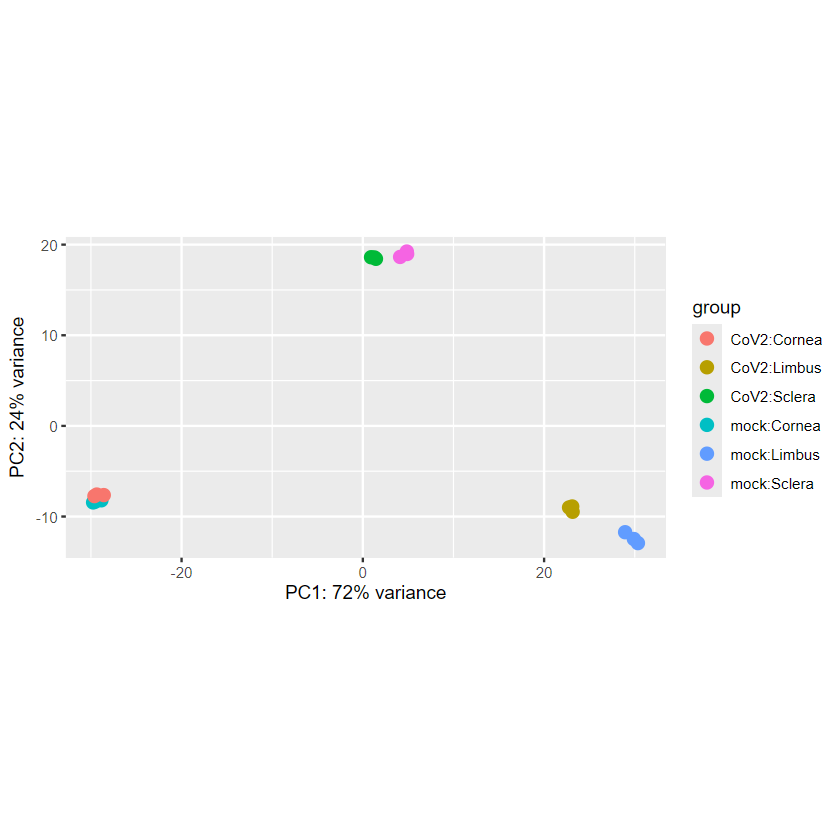

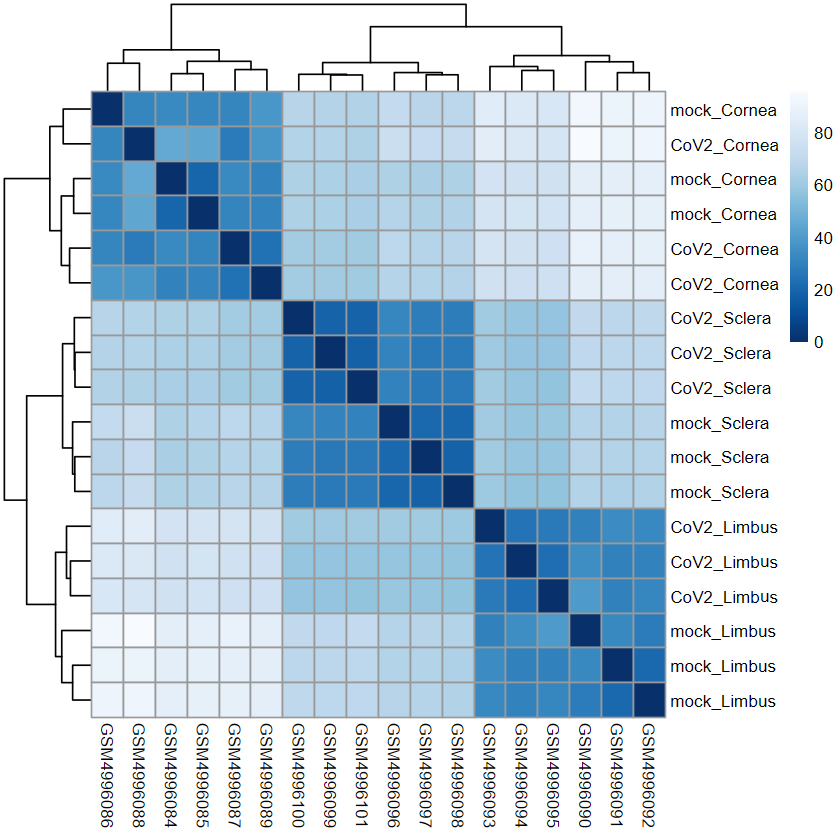

In [13]:
library(pheatmap, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
# Variance stabilizing transformation for plotting
vsd <- vst(dds, blind = FALSE)

# PCA plot to assess sample clustering
DESeq2::plotPCA(vsd, intgroup = c("condition", "tissue"))

# Sample distance heatmap
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$tissue, sep = "_")
pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         color = colorRampPalette(rev(brewer.pal(9, "Blues")))(255))

In [14]:
# Contrast: CoV2 vs mock, across tissues
res <- results(dds, contrast = c("condition", "CoV2", "mock"))

# Sort by adjusted p-value
res <- res[order(res$padj), ]

# Summary
summary(res)

# Save results
res_df <- as.data.frame(res)
print(res_df)


out of 23713 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1523, 6.4%
LFC < 0 (down)     : 2017, 8.5%
outliers [1]       : 0, 0%
low counts [2]     : 5517, 23%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

              baseMean log2FoldChange      lfcSE        stat        pvalue
6648      1.097075e+04    2.929584613 0.08254421  35.4910977 6.743719e-276
7128      4.346902e+02    1.826858852 0.06668715  27.3944676 3.192016e-165
176       1.570387e+03   -1.982128331 0.09315566 -21.2775936 1.831017e-100
718       3.696174e+03    2.077636688 0.09885912  21.0161361  4.669338e-98
140876    3.392908e+02    1.795313296 0.10820583  16.5916497  8.008986e-62
70        5.718185e+02   -2.005313306 0.12594858 -15.9216821  4.481644e-57
7127      6.108358e+02    1.480832395 0.09497721  15.5914498  8.322316e-55
771       1.502898e+03    0.933448281 0.06093664  15.3183407  5.767105e-53
5737      2.004070e+03 